# Modeling Heights

In [1]:
import pandas as pd
from matplotlib import pyplot as plt, colors
import numpy as np

In [2]:
# Some settings for making pretty plots

prop_cycle = plt.rcParams['axes.prop_cycle']
cs = [colors.to_rgb(c) for c in prop_cycle.by_key()['color']]
r0, g0, b0 = cs[0]
r1, g1, b1 = cs[1]
r2, g2, b2 = cs[2]

In [3]:
df = pd.read_csv("./height.csv")
df

,Height,Gender
0,73.847017,Male
1,68.781904,Male
2,74.110105,Male
3,71.730978,Male
4,69.881796,Male
...,...,...
9995,66.172652,Female
9996,67.067155,Female
9997,63.867992,Female
9998,69.034243,Female


In [4]:
df = df.sample(frac=1).reset_index(drop=True) # Shuffle the rows.
X = df.Height.values
y = 1*(df.Gender == "Female").values

MALE = 0
FEMALE = 1

# boolean array indexing: https://numpy.org/devdocs/reference/arrays.indexing.html#boolean-array-indexing
X_m = X[y == MALE]
X_f = X[y == FEMALE]

y = 1*(y == FEMALE)

n_m = len(X_m)
n_f = len(X_f)

print(f"Data set contains heights of {n_m} men and {n_f} women.") # format string

Data set contains heights of 5000 men and 5000 women.


### Density Estimation

Estimate the densities for:

1. the heights of women,
2. the heights of men, and
3. the heighs of both women and men.

Do this
1. nonparametrically, using histograms, and
2. parametrically, by assuming the distribution of the heights of women and the distribution of the heights of men are both Gaussian.

In [5]:
m_m = np.mean(X_m)
s_m = np.std(X_m)

m_f = np.mean(X_f)
s_f = np.std(X_f)

m_all = np.mean(X)
s_all = np.std(X)

p_m = n_m/(n_m + n_f)
p_f = n_f/(n_m + n_f)

#### Gaussian density:

$$
g(x|\mu,\sigma) = \frac1{\sqrt{2\pi}\sigma}\exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
$$

In [6]:
# Gaussian density

def g(x, mu, sigma):
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x - mu)**2/(2*sigma**2))

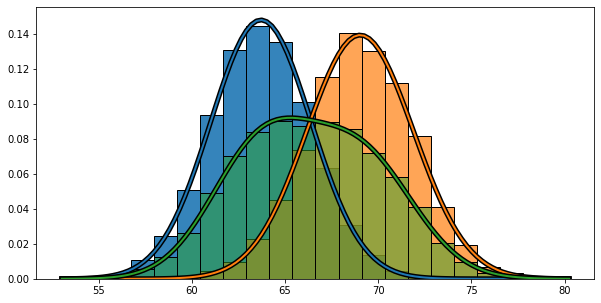

In [7]:
_, bins = np.histogram(X, bins=20, density=True);

plt.figure(figsize=(10, 5))

plt.hist(X_f, bins=bins, density=True, color=(r0, g0, b0, 0.9), edgecolor='black')
plt.hist(X_m, bins=bins, density=True, color=(r1, g1, b1, 0.7), edgecolor='black');
plt.hist(X, bins=bins, density=True, color=(r2, g2, b2, 0.5), edgecolor='black');

xmin, xmax = plt.xlim()

x = np.linspace(xmin, xmax, 100)

h_m = g(x, m_m, s_m) # vectorized
h_f = g(x, m_f, s_f) # vectorized
h = p_m*h_m + p_f*h_f # mixture

plt.plot(x, h_f, 'k-', lw=5)
plt.plot(x, h_f, 'k-', lw=2, color=(r0, g0, b0))
plt.plot(x, h_m, 'k-', lw=5)
plt.plot(x, h_m, 'k-', lw=2, color=(r1, g1, b1))
plt.plot(x, h, 'k-', lw=5)
plt.plot(x, h, 'k-', lw=2, color=(r2, g2, b2))
# plt.plot(x, y, 'r--', lw=4)
# plt.plot(x, g(x, m0, s0), 'r--', lw=4)
# plt.plot(x, g(x, m1, s1), 'r--', lw=4)

## Unsupervised Learning

### $K$-Means Clustering

Cluster the data using the $K$-means algorithm. Do the clusters reflect genders?

In [8]:
from sklearn.cluster import KMeans

M = KMeans(n_clusters=2)
labels = M.fit_predict(X.reshape(-1, 1))
print("Cluster accuracy: ", labels[y == 0].sum()/5000, labels[y == 1].sum()/5000)

Cluster accuracy:  0.8214 0.1552


### Gaussian Mixture Model

Without using gender information, model the heights as a mixture of two Gaussians.
Use your model to *predict* gender based on height.

In [9]:
from sklearn.mixture import GaussianMixture

M = GaussianMixture(n_components=2)
labels = M.fit_predict(X.reshape(-1, 1))

In [10]:
print("Cluster accuracy: ", labels[y == 0].sum()/5000, labels[y == 1].sum()/5000)

Cluster accuracy:  0.1812 0.846


In [11]:
m_0, m_1 = M.means_
s_0, s_1 = np.sqrt(M.covariances_).squeeze()
w_0, w_1 = M.weights_

In [12]:
d_0 = g(x, m_0, s_0)
d_1 = g(x, m_1, s_1)
d = w_0*d_0 + w_1*d_1

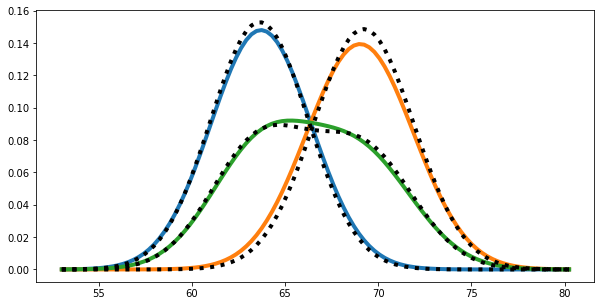

In [13]:
plt.figure(figsize=(10, 5))

plt.plot(x, h_f, '-', lw=4, color=(r0, g0, b0))
plt.plot(x, h_m, '-', lw=4, color=(r1, g1, b1))
plt.plot(x, h, '-', lw=4, color=(r2, g2, b2))

plt.plot(x, d_0, 'k:', lw=4)
plt.plot(x, d_1, 'k:', lw=4)
plt.plot(x, d, 'k:', lw=4);

## Supervised Learning

### Train/Test Split

In [14]:
X_train = X[:9000].reshape(-1, 1)
y_train = y[:9000]
X_test = X[9000:].reshape(-1, 1)
y_test = y[9000:]

### Logistic Regression

$$
p(y=1|x) = \frac{1}{1 + \exp\big(-(\beta_0 + \beta_1x)\big)}
$$

In [15]:
def lr(x, beta_0, beta_1):
    return 1/(1 + np.exp(-(beta_0 + beta_1*x)))

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
M = LogisticRegression(solver="lbfgs")
M.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
y_predict = M.predict(X_test)
print(f"Accuracy on test set: {np.sum(y_predict == y_test)/len(y_test)}")

Accuracy on test set: 0.833


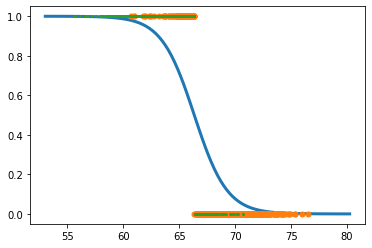

In [19]:
beta_0 = M.intercept_.item()
beta_1 = M.coef_.item()
plt.plot(x, lr(x, beta_0, beta_1), '-', lw=3)

plt.plot(X_test[y_test == 0], y_predict[y_test == 0], 'o', markersize=5, color=(r1, g1, b1))
plt.plot(X_test[y_test == 1], y_predict[y_test == 1], 'o', markersize=2, color=(r2, g2, b2));

### The Bayes Classifier

$$
\begin{aligned}
x&\in\mathbb{R}&&\text{height}\\
\\
z&\in\{\text{male, female}\}&&\text{class label}\\
\\
p(z=i|x) &= \frac{p(x|z=i)p(z=i)}{p(x)}&&\text{Bayes' Theorem}\\
&= \frac{p(x|z=i)p(z=i)}{p(x|z=0)p(z=0) + p(x|z=1)p(z=1)}&&\text{by the Law of Total Probability}
\end{aligned}
$$

In [20]:
X_female = X_train[y_train == FEMALE]
X_male = X_train[y_train == MALE]

bins = np.arange(np.floor(np.min(X_train)), np.ceil(np.max(X_train)))

hist_female, bins_female = np.histogram(X_female, bins=bins, density=True)
hist_male, bins_male = np.histogram(X_male, bins=bins, density=True)

In [21]:
bins = bins.reshape(1, -1)

p_female = len(X_female)/(len(X_female) + len(X_male))
p_male = len(X_male)/(len(X_female) + len(X_male))

p_x_female = hist_female[np.argmin(X_test > bins, axis=1) - 1]
p_x_male = hist_male[np.argmin(X_test > bins, axis=1) - 1]

p_x = p_x_female*p_female + p_x_male*p_male
p_female_x = p_x_female*p_female/p_x
p_male_x = p_x_male*p_male/p_x

In [22]:
y_pred = 1.0*(p_male_x < p_female_x)

In [23]:
np.sum(y_pred == y_test)/len(y_test)

0.839